<a href="https://colab.research.google.com/github/bognevivien/text-classification/blob/main/classy_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing dependencies

In [1]:
!pip install classy-classification onnx --no-use-pep517 -q


     |████████████████████████████████| 13.1 MB 4.7 MB/s 
     |████████████████████████████████| 135 kB 80.0 MB/s 
     |████████████████████████████████| 85 kB 5.0 MB/s 
     |████████████████████████████████| 5.5 MB 66.5 MB/s 
     |████████████████████████████████| 1.3 MB 75.9 MB/s 
     |████████████████████████████████| 182 kB 83.2 MB/s 
     |████████████████████████████████| 53 kB 2.0 MB/s 
     |████████████████████████████████| 4.7 MB 71.6 MB/s 
     |████████████████████████████████| 1.1 MB 80.9 MB/s 
     |████████████████████████████████| 6.6 MB 83.8 MB/s 
     |████████████████████████████████| 17.0 MB 67.7 MB/s 
     |████████████████████████████████| 308 kB 92.7 MB/s 
     |████████████████████████████████| 548 kB 81.4 MB/s 
     |████████████████████████████████| 68 kB 8.3 MB/s 
     |████████████████████████████████| 128 kB 65.8 MB/s 
     |████████████████████████████████| 296 kB 71.2 MB/s 
     |████████████████████████████████| 4.5 MB 55.2 MB/s 
     |█████████████

In [2]:
!pip install python-dotenv -q

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Importing librairies


In [12]:
import spacy
import classy_classification

from dotenv import dotenv_values

from google.colab import drive


# Importing environment variables

In [5]:
config = dotenv_values(".env")  

In [100]:
# config['dbname']

# Mounting drive

In [13]:
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Nov 23 13:45:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    49W / 400W |    658MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [15]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


# Collecting the data

## From database

### pandas read_sql stream_results function

In [18]:
import pandas as pd
from sqlalchemy import create_engine
from tqdm import tqdm
tqdm.pandas()


def getting_data_from_table(tablename="product", chuncksize=100000):
    engine = create_engine(
        f"postgresql://{config['user']}:{config['pwd']}@{config['hostname']}/{config['dbname']}"
    )
    dfs = pd.DataFrame()
    # First Round trip to get total items for monitoring purpose
    total_items_df = pd.read_sql(
        "select count(*) from {} ".format(tablename), engine.connect())
    total_items = total_items_df['count'][0]
    total = int(total_items/chuncksize)+1

    conn = engine.connect().execution_options(stream_results=True)
    query = "SELECT * FROM {} ".format(tablename)

    i = 0
    for chunk_dataframe in tqdm(pd.read_sql(query, conn, chunksize=chuncksize), desc="getting {} records from {} as dataframe using {} chunks".format(total_items, tablename, total), total=total):
        # print(f"Got dataframe w/{len(chunk_dataframe)} rows")
        # ... do something with dataframe ...
        dfs = pd.concat([dfs, chunk_dataframe])
        # chunk_dataframe.to_pickle('../data/data_chunks/attributes_names/chunk_{}'.format(i))
        # i = i+1
    return dfs.replace(['', 'nan', 'NaN', 'NA', 'null'], [None, None, None,None, None])
# if __name__ == '__main__':
#     process_sql_using_pandas()



### Getting products from db

In [19]:
products = getting_data_from_table(tablename="product")


getting 1693829 records from product as dataframe using 17 chunks: 100%|██████████| 17/17 [01:31<00:00,  5.40s/it]


## From BI

In [34]:
data_bi = pd.read_excel('/content/drive/MyDrive/classification 2020-2022.xlsx', sheet_name='Classification from BI filters ')

In [35]:
data_bi.shape

(665443, 8)

# Loading the data

In [ ]:
data = {
    "furniture": ["This text is about chairs.",
               "Couches, benches and televisions.",
               "I really need to get a new sofa."],
    "kitchen": ["There also exist things like fridges.",
                "I hope to be getting a new stove today.",
                "Do you also have some ovens."]
}

In [22]:
# import pickle
# f = open('/content/drive/MyDrive/data.pkl', 'rb')
# data_db = pickle.load(f)
# f.close()

In [36]:
data_bi.sample(4)

,Supplier Name,PO Item Description,PO Text,Item Text,PO Description,Purchasing Family Code,Purchased Amount,% Purchased Amount
246708,SCHRACK TECHNIK GmbH,"CEE-Verteilereinbaudose 5x16A, 400V, IP4",YY494518--,"CEE-Verteilereinbaudose 5x16A, 400V, IP44,Huts...",NaN,AHELIA17,36.1,2.4e-06
550713,SONEPAR Deutschland,"0428067 CIM 6-RUND-ALLZWECKSCHRAUBE 4,",NaN,"CIMCO 6-rund-Allzweckschraube 4,5x45 T20 vz Ha...",NaN,AHELIA16,7.2,4e-07
416731,Adolf Würth GmbH & Co. KG,GESIHMASK-MEDZ-TYP-IIR-EN14683,0899110011730 50,NaN,NaN,AGENTR12,13.52,6e-07
384392,SONEPAR Deutschland,0430175 OBO POTENTIALAUSGL.SCH 5015081,NaN,OBO BETT. Potentialausgl.schiene Type alt: 183...,NaN,AHELIA16,32.12,1.4e-06


# Exploratory Data Analysis

In [37]:
data_bi.dtypes

Supplier Name             object
PO Item Description       object
PO Text                   object
Item Text                 object
PO Description            object
Purchasing Family Code    object
Purchased Amount          object
% Purchased Amount        object
dtype: object

> Our first approach will be to concatenate all text from supplier to description

In [40]:
data_bi['text'] = data_bi[['Supplier Name', 'PO Item Description', 'PO Text', 'Item Text', 'PO Description']].astype(str).progress_apply(lambda x: " ".join(x), axis=1)

100%|██████████| 665443/665443 [00:06<00:00, 105200.79it/s]


In [41]:
data_bi['PO Item Description'].isna().value_counts()

False    665423
True         20
Name: PO Item Description, dtype: int64

In [50]:
data_bi_text_cats = data_bi[['text', 'Purchasing Family Code']]
data_bi_text_cats.columns = ['text', 'cats']

In [92]:
data_bi_text_cats.cats.value_counts()

AHELIA16    215966
AGENTR12     48307
AHELIA12     42086
AOAUIN10     41380
BDHWRE10     36005
             ...  
AJBUMA15         2
ARDIFL16         2
APFLPR24         1
ARDIFL24         1
ARDIFL30         1
Name: cats, Length: 103, dtype: int64

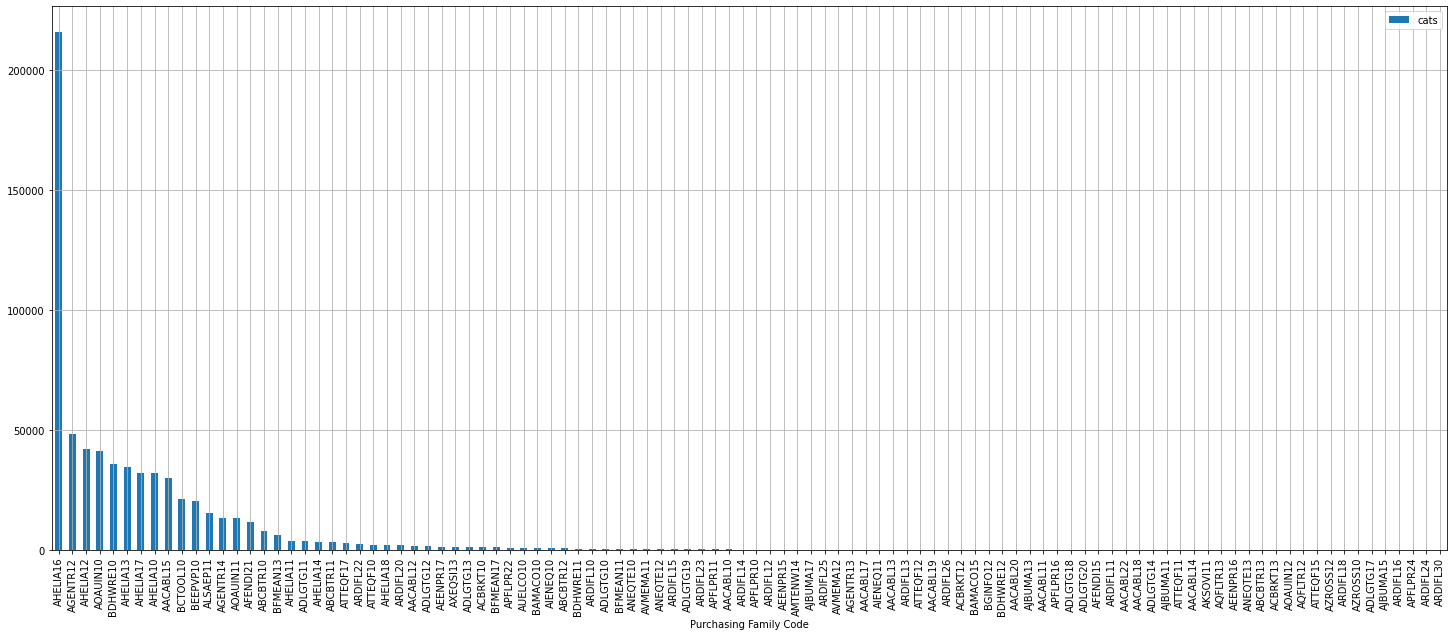

In [89]:
ax = data_bi_text_cats.cats\
                 .value_counts()\
                 .drop('Purchasing Family Code')\
                 .plot(kind='bar', \
                       xlabel='Purchasing Family Code',\
                       fontsize=10,\
                       figsize=(25,10), \
                       grid=True, legend=True)

# Preparation of the Data

## Balancing the data

In [90]:
# Credits: https://medium.com/analytics-vidhya/undersampling-and-oversampling-an-old-and-a-new-approach-4f984a0e8392
# cats is the column to resample

def oversample(df):
    classes = df.cats.value_counts().to_dict()
    most = max(classes.values())
    classes_list = []
    for key in classes:
        classes_list.append(df[df['cats'] == key]) 
    classes_sample = []
    for i in range(1,len(classes_list)):
        classes_sample.append(classes_list[i].sample(most, replace=True))
    df_maybe = pd.concat(classes_sample)
    final_df = pd.concat([df_maybe,classes_list[0]], axis=0)
    final_df = final_df.reset_index(drop=True)
    return final_df

def undersample(df):
    classes = df.cats.value_counts().to_dict()
    least_class_amount = min(classes.values())
    classes_list = []
    for key in classes:
        classes_list.append(df[df['cats'] == key]) 
    classes_sample = []
    for i in range(0,len(classes_list)-1):
        classes_sample.append(classes_list[i].sample(least_class_amount))
    df_maybe = pd.concat(classes_sample)
    final_df = pd.concat([df_maybe,classes_list[-1]], axis=0)
    final_df = final_df.reset_index(drop=True)
    return final_df

In [93]:
cats_series = data_bi_text_cats.cats.value_counts()> 30000

cats_to_sample = cats_series.where( cats_series == False).dropna().index
cats_to_sample


Index(['AACABL15', 'BCTOOL10', 'BEEPVP10', 'ALSAEP11', 'AGENTR14', 'AOAUIN11',
       'AFENDI21', 'ABCBTR10', 'BFMEAN13', 'AHELIA11', 'ADLGTG11', 'AHELIA14',
       'ABCBTR11', 'ATTEQF17', 'ARDIFL22', 'ATTEQF10', 'AHELIA18', 'ARDIFL20',
       'AACABL12', 'ADLGTG12', 'AEENPR17', 'AXEQSI13', 'ADLGTG13', 'ACBRKT10',
       'BFMEAN17', 'APFLPR22', 'AUELCO10', 'BAMACO10', 'AIENEQ10', 'ABCBTR12',
       'BDHWRE11', 'ARDIFL10', 'ADLGTG10', 'BFMEAN11', 'ANEQTE10', 'AVMEMA11',
       'ANEQTE12', 'ARDIFL15', 'ADLGTG19', 'ARDIFL23', 'APFLPR11', 'AACABL10',
       'ARDIFL14', 'APFLPR10', 'ARDIFL12', 'AEENPR15', 'AMTENW14', 'AJBUMA17',
       'ARDIFL25', 'AVMEMA12', 'AGENTR13', 'AACABL17', 'AIENEQ11', 'AACABL13',
       'ARDIFL13', 'ATTEQF12', 'AACABL19', 'ARDIFL26', 'ACBRKT12', 'BAMACO15',
       'BGINFO12', 'BDHWRE12', 'AACABL20', 'AJBUMA13', 'AACABL11', 'APFLPR16',
       'ADLGTG18', 'ADLGTG20', 'AFENDI15', 'ARDIFL11', 'AACABL22', 'AACABL18',
       'ADLGTG14', 'AJBUMA11', 'ATTEQF11', 'AACABL14

In [96]:
downsampling_above_30000= undersample(data_bi_text_cats.query('~cats.isin(@cats_to_sample)', engine='python'))
downsampling_above_30000.shape

(255648, 2)

In [97]:
oversampling_under_30000= oversample(data_bi_text_cats.query('cats.isin(@cats_to_sample)', engine='python'))
oversampling_under_30000.shape

(2844870, 2)

In [98]:
train_test_val_df = pd.concat([downsampling_above_30000, oversampling_under_30000])

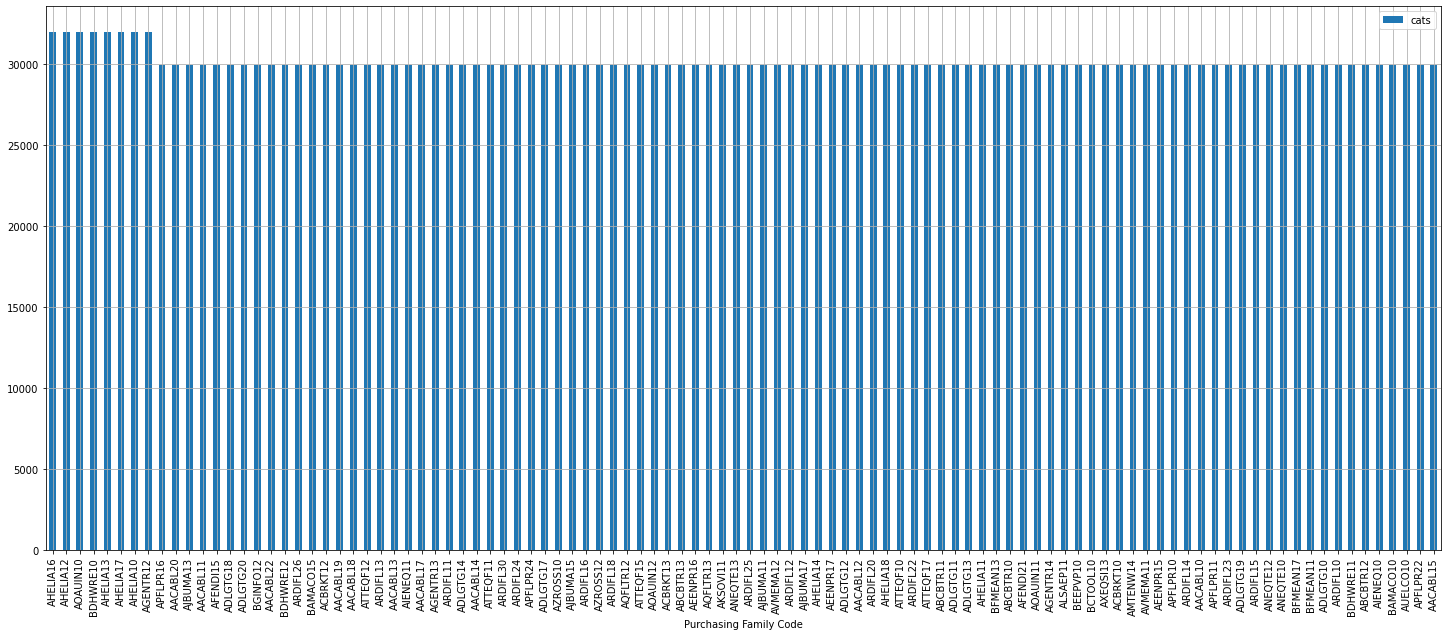

In [99]:
ax = train_test_val_df.cats\
                 .value_counts()\
                 .drop('Purchasing Family Code')\
                 .plot(kind='bar', \
                       xlabel='Purchasing Family Code',\
                       fontsize=10,\
                       figsize=(25,10), \
                       grid=True, legend=True)

## Formatting the data

In [101]:
train_test_val_df.shape

(3100518, 2)

# Modeling

## Classification using bert-base

In [ ]:
nlp = spacy.blank("en")
nlp.add_pipe(
    "text_categorizer",
    config={
        "data": data,
        "model": "bert-base-multilingual-cased",
        # "cat_type": "zero",
        "device": "gpu"
    }
)

print(nlp("I am looking for kitchen appliances.")._.cats)

# Output:
#
# [{"label": "furniture", "score": 0.21}, {"label": "kitchen", "score": 0.79}]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Ignore MatMul due to non constant B: /[MatMul_149]
Ignore MatMul due to non constant B: /[MatMul_154]
Ignore MatMul due to non constant B: /[MatMul_243]
Ignore MatMul due to non constant B: /[MatMul_248]
Ignore MatMul due to non constant B: /[MatMul_337]
Ignore MatMul due to non constant B: /[MatMul_342]
Ignore MatMul due to non constant B: /[MatMul_431]
Ignore MatMul due to non constant B: /[MatMul_436]
Ignore MatMul due to non constant B: /[MatMul_525]
Ignore MatMul due to non constant B: /[MatMul_530]
Ignore MatMul due to non constant B: /[MatMul_619]
Ignore MatMul due to non constant B: /[MatMul_624]
Ignore MatMul due to non constant B: /[MatMul_713]
Ignore MatMul due to non constant B: /[MatMul_718]
Ignore MatMul due to non constant B: /[MatMul_807]
Ignore MatMul due to non constant B: /[MatMul_812]
Ignore MatMul due to non constant B: /[MatMul_901]
Ignore MatMul due to non constant B: /[MatMul_906]
Ignore MatMul due to non constant B: /[MatMul_995]
Ignore MatMul due to non consta

## Classification using Spacy model

In [ ]:
data = {
    "furniture": ["This text is about chairs.",
               "Couches, benches and televisions.",
               "I really need to get a new sofa."],
    "kitchen": ["There also exist things like fridges.",
                "I hope to be getting a new stove today.",
                "Do you also have some ovens."]
}

nlp = spacy.blank("en")
nlp.add_pipe(
    "text_categorizer",
    config={
        "data": data,
        "model": "Sahajtomar/french_semantic",
        "device": "gpu"
    }
)

print(nlp("I am looking for kitchen appliances.")._.cats)

# Output:
#
# [{"label": "furniture", "score": 0.21}, {"label": "kitchen", "score": 0.79}]

In [ ]:
print(nlp("texts about dinner tables have multiple labels.")._.cats)

{'furniture': 0.5728549746113443, 'kitchen': 0.4271450253886556}


## Classification using sentence transformer

In [31]:
import pandas as pd 

bi_data = pd.read_csv('classification.csv', header=1)

In [32]:
bi_data

,Supplier Name,Procurement Type,Procurement Tool,PO Item Description,PO Text,Unnamed: 5,Unnamed: 6
0,SIEMENS AG,Punchout,Punchout,SINAMICS S120 Single Motor-Module Eingan,NaN,929372.74,0.006495
1,SIEMENS AG,Punchout,Punchout,SIMATIC PCS 7 CPU 410 Redundancy Automat,NaN,701391.00,0.004901
2,SIEMENS AG,Punchout,Punchout,"SIMATIC PCS 7, Software, Upgrade Package",NaN,497655.39,0.003478
3,SIEMENS AG,Punchout,Punchout,Einschub-Leistungsschalter mit Einschubr,NaN,479175.91,0.003348
4,Klaus Faber AG,Punchout,Punchout,NYY-O 01X240 SW,NaN,466938.91,0.003263
...,...,...,...,...,...,...,...
312997,Technische Unie B.V.,Punchout,Punchout,JUNG 1731DD DIM UN LED,6442683,-5492.98,-0.000038
312998,Technische Unie B.V.,Punchout,Punchout,Credit,3ceb0349-b7b6-44f3-b3ed-07e620d23af0,-5741.77,-0.000040
312999,Technische Unie B.V.,Punchout,Punchout,GROH EUROECO/C T WASTKR K/W,4602769,-6144.13,-0.000043
313000,ZUID NEDERLANDSE BUIZEN BV,Punchout,Punchout,KORTING,NaN,-21512.81,-0.000150


UnpicklingError: ignored

In [ ]:
type(data)

dict

In [ ]:
import pandas as pd
data_df = pd.DataFrame(data)
data_df.shape

(413043, 40)

In [ ]:
data_df_clean = data_df.dropna()
data_df_clean.shape

(413009, 40)

In [ ]:
data = data_df_clean.to_dict("list")

In [ ]:
len(data)

40

In [ ]:
nlp = spacy.blank("fr")
nlp.add_pipe(
    "text_categorizer",
    config={
        "data": data,
        "model": "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
        "device": "gpu"
    }
)


Ignore MatMul due to non constant B: /[MatMul_149]
Ignore MatMul due to non constant B: /[MatMul_154]
Ignore MatMul due to non constant B: /[MatMul_243]
Ignore MatMul due to non constant B: /[MatMul_248]
Ignore MatMul due to non constant B: /[MatMul_337]
Ignore MatMul due to non constant B: /[MatMul_342]
Ignore MatMul due to non constant B: /[MatMul_431]
Ignore MatMul due to non constant B: /[MatMul_436]
Ignore MatMul due to non constant B: /[MatMul_525]
Ignore MatMul due to non constant B: /[MatMul_530]
Ignore MatMul due to non constant B: /[MatMul_619]
Ignore MatMul due to non constant B: /[MatMul_624]
Ignore MatMul due to non constant B: /[MatMul_713]
Ignore MatMul due to non constant B: /[MatMul_718]
Ignore MatMul due to non constant B: /[MatMul_807]
Ignore MatMul due to non constant B: /[MatMul_812]
Ignore MatMul due to non constant B: /[MatMul_901]
Ignore MatMul due to non constant B: /[MatMul_906]
Ignore MatMul due to non constant B: /[MatMul_995]
Ignore MatMul due to non consta

In [ ]:
type(nlp)

In [ ]:
data_df_clean.iloc[3, :2]

41    Copal Electronics Potentiomètre Rotatif 20kΩ 3...
32    Condensateur tantale KEMET CMS 47μF 10V c.c. b...
Name: 3, dtype: object

In [ ]:
max(nlp("Condensateur Crouzet, 480 V c.a., pour 825400")._.cats, key=nlp("Condensateur Crouzet, 480 V c.a., pour 825400")._.cats.get)

'26'

In [ ]:
nlp("Condensateur Crouzet, 480 V c.a., pour 825400")._.cats

{'10': 0.00476714603033662,
 '11': 0.009471865317405612,
 '12': 0.02439224916973389,
 '13': 0.019857559123909265,
 '14': 0.004471647388392354,
 '15': 0.025325584801012706,
 '20': 0.006238648388988998,
 '21': 0.0026165190638884565,
 '22': 0.004260088257322503,
 '23': 0.022798049051493227,
 '24': 0.027921228164213063,
 '25': 0.014580753947029663,
 '26': 0.12490890930956529,
 '27': 0.030023244475532337,
 '30': 0.01686975154374761,
 '31': 0.03225414511108506,
 '32': 0.12487818263456757,
 '34': 0.016480075013015256,
 '39': 0.012888013668829086,
 '40': 0.06415657681883101,
 '41': 0.011870912457535457,
 '42': 0.02777276393272875,
 '43': 0.03424097832759138,
 '44': 0.0453848079850196,
 '45': 0.06512114117217559,
 '46': 0.02505363338400749,
 '47': 0.05152498952308339,
 '50': 0.003448615461080589,
 '52': 0.015066773861851844,
 '53': 0.0044097897133425,
 '54': 0.002824302608231271,
 '55': 0.021329691803715505,
 '56': 0.021958640067783988,
 '60': 0.019528080806045428,
 '72': 0.025961421049836814,
